In [2]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform import *
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir  = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

## Audio Processing using Librosa and soundfile

* Detects audio files that contain clipping and removes them from the data set
* Filters out beginning and end silence 
* Normalizes loudness

In [3]:
import librosa #Need to pip install librosa 
import soundfile as sf #Need to pip install soundfile
from joblib import Parallel, delayed
import numpy as np

In [ ]:
#Creates new wav files that have been processed

CLIP_THRESHOLD = 0.99
OUTPUT_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav-processed')

def is_clipped(y, threshold = CLIP_THRESHOLD):
    return np.any(np.abs(y) >= threshold)

def normalize_peaks(y):
    return y / np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else y

def normalize_pitch_shifting(y, sr, target_hz=150.0):
    f0, voiced_flag, _ = librosa.pyin(y, 
                                      fmin=librosa.note_to_hz('C2'), 
                                      fmax=librosa.note_to_hz('C7'))
    
    voiced_f0 = f0[voiced_flag]
    voiced_f0 = voiced_f0[~np.isnan(voiced_f0)]

    current_pitch_hz = np.median(voiced_f0)
    if current_pitch_hz <= 0:
        return y
    n_steps = 12 * np.log2(target_hz / current_pitch_hz)

    y_shifted = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)
    
    return y_shifted

def process_audio_file(filename):
    if filename.lower().endswith('wav'):
        path_in = os.path.join(data_dir, filename)
        path_out = os.path.join(OUTPUT_DIR, filename)
        
        y, sr = librosa.load(path_in, sr=None)

        if is_clipped(y):
            return

        y_trimmed, _ = librosa.effects.trim(y, top_db=20)

        y_loudness_normalized = normalize_peaks(y_trimmed) 
        
        # pitch normalization
        y_normalized = normalize_pitch_shifting(y_loudness_normalized, sr, target_hz=150.0)

        sf.write(path_out, y_normalized, sr)

try:
    os.mkdir(OUTPUT_DIR)
except FileExistsError:
    pass

total_files = len(file_names)
print(f"Starting processing for {total_files} files...")

Parallel(n_jobs=-1)(delayed(process_audio_file)(filename) for filename in tqdm(file_names, desc="Processing audio files"))

print("\nProcessing complete. All files have been handled.")


In [4]:
#Changes dataset to post-processed dataset
data_dir = OUTPUT_DIR
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

## numpy representation

using `scipy.io.wavfile.read(filename)` to intake .wav audio files 

> returns 
> * rate, registing the hertz of the audio 
> * data, an array with each index representing a point in time for the audio and its value representing amplitude at said time 
>   * index position divided by the length of array represents its temporal occurence in seconds

In [5]:
from scipy.io import wavfile

In [6]:
wav_rates, wav_coeffs = zip(*[wavfile.read(file) for file in file_list])
wav_rates = np.array(wav_rates)
wav_coeffs = np.array(wav_coeffs, dtype="object")

In [7]:
assert len(wav_rates) == len(wav_rates), "Check for lossy data in .wav scipy numpy representation"
n = len(wav_rates)
n

1420

In [8]:
wav_lengths = pd.Series(wav_coeffs).apply(len) / wav_rates[0]

## info parsing to .csv

file naming conventions (from RAVDESS)

In [9]:
modalities = {
    "01": "full-AV", 
    "02": "video-only",
    "03": "audio-only"
} 

channels = {
    "01": "speech",
    "02": "song"
}

emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "suprised",
} 

intensities = {
    "01": "normal",
    "02": "strong"
}

statements = {
    "01": "Kids are talking by the door",
    "02": "Dogs are sitting by the door"
}

speaker_sex = ["female", "male"] 

In [10]:
ravdess_cols = ["modality", "channel", "emotion", "intensity", "statement", "repetition", "actor", "sex", "filename"]
rows = []

for f in file_names:
    if f != ".DS_Store":
        parsed_info = f[:-4].split("-")

        modality = modalities[parsed_info[0]]
        channel = channels[parsed_info[1]]
        emotion = emotions[parsed_info[2]]
        intensity = intensities[parsed_info[3]]
        sentence = statements[parsed_info[4]]
        rep = int(parsed_info[5])
        no1 = int(parsed_info[6])
        sx = speaker_sex[no1 % 2]

        rows.append({
            "modality": modality,
            "channel": channel,
            "emotion": emotion,
            "intensity": intensity,
            "statement": sentence,
            "repetition": rep,
            "actor": no1,
            "sex": sx,
            "filename": f
        })

ravdess_df = pd.DataFrame(rows, columns=ravdess_cols)


ravdess_df["length (s)"] = wav_lengths
ravdess_df["rate (Hz)"] = wav_rates
ravdess_df["amplitudes"] = wav_coeffs

ravdess_df.head()

,modality,channel,emotion,intensity,statement,repetition,actor,sex,filename,length (s),rate (Hz),amplitudes
0,audio-only,speech,fearful,normal,Dogs are sitting by the door,2,2,female,03-01-06-01-02-02-02.wav,1.664000,48000,"[-238, -64, 132, 213, 231, 127, 41, -15, 52, 7..."
1,audio-only,speech,angry,normal,Dogs are sitting by the door,1,16,female,03-01-05-01-02-01-16.wav,1.834667,48000,"[-38, -44, -17, -6, 8, 3, -34, -43, -22, -3, 1..."
2,audio-only,speech,suprised,normal,Kids are talking by the door,1,14,female,03-01-08-01-01-01-14.wav,1.610667,48000,"[366, 821, 701, 529, 194, -163, -354, -210, -9..."
3,audio-only,speech,fearful,normal,Dogs are sitting by the door,2,16,female,03-01-06-01-02-02-16.wav,1.493333,48000,"[-363, 2128, 2318, 1274, -354, -1033, -431, -1..."
4,audio-only,speech,angry,normal,Dogs are sitting by the door,1,2,female,03-01-05-01-02-01-02.wav,1.664000,48000,"[-31, -32, -24, -23, -15, -5, -11, -18, -10, -..."


In [11]:
xport_name = "full-ravdess.csv"
EXPORT_DIR = os.path.join(ROOT_DIR, "raw-data", "ravdess")
EXPORT_PATH = os.path.join(EXPORT_DIR, xport_name)

ravdess_df.to_csv(EXPORT_PATH)

## npz representation export

In [12]:
EXPORT_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-npz')

try:
    os.mkdir(EXPORT_DIR)
except FileExistsError:
    pass

for f in np.arange(len(file_list)):
    coef = wav_coeffs[f]
    file_name = file_list[f][-24:-4] ## removes the .wav naming convention

    np.savez(os.path.join(EXPORT_DIR, file_name))

## banding

consideration for a "banding method" to group adjacent audio bytes in a similar fashion to how the image teams doing 

* tied to the transformation in use 

# Wavelet representation
Morlet continuous wavelet transform on some example files to start

In [13]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [14]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal = wavfile.read(file_list[test_file_idx])

wavelet = 'cmor1.5-1.0' # complex morlet: bandwidth = 1.5, center frequency = 1.0
low_freq, high_freq = 80, 8000  # typical range for human speech
num_scales = 100  # can be adjusted for computational efficiency

frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
scales = pywt.frequency2scale(wavelet, frequencies / rate)
coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

modality                                             audio-only
channel                                                  speech
emotion                                                     sad
intensity                                                normal
statement                          Dogs are sitting by the door
repetition                                                    2
actor                                                        23
sex                                                        male
filename                               03-01-04-01-02-02-23.wav
length (s)                                             1.621333
rate (Hz)                                                 48000
amplitudes    [-607, -3223, -2154, -1752, 615, -936, -2418, ...
Name: 42, dtype: object


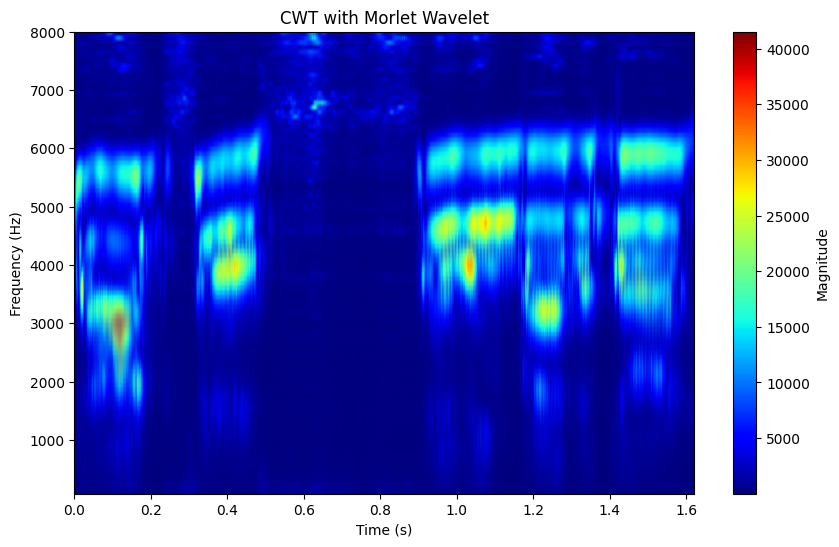

In [15]:
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(coefs),
    aspect='auto',
    cmap='jet',
    extent=[0, len(signal)/rate, low_freq, high_freq]
)
plt.colorbar(label='Magnitude')
# plt.yscale('log') # log scale frequency axis
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('CWT with Morlet Wavelet')
plt.show()

In [16]:
# generalize above logic into function

def cwt_file(filename, wavelet='cmor1.5-1.0', low_freq=80, high_freq=8000, num_scales=100, visualize=False, title='CWT with Morlet Wavelet'):
    rate, signal = wavfile.read(os.path.join(data_dir, filename)) # currently references global data_dir
    frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
    scales = pywt.frequency2scale(wavelet, frequencies / rate)
    coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.imshow(
            np.abs(coefs),
            aspect='auto',
            cmap='jet',
            extent=[0, len(signal)/rate, low_freq, high_freq]
        )
        plt.colorbar(label='Magnitude')
        # plt.yscale('log')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(title)
        plt.show()

    return coefs, freqs

In [17]:
# compare male versus female

from functools import reduce

def homogenize(df, *cols):
    return df[reduce(lambda a, b: a & b, (df[col] == df[col][0] for col in cols), np.ones(df.shape[0]))]

hom_df = homogenize(ravdess_df, 'statement', 'emotion', 'intensity')
male_vs_female = hom_df.groupby('sex').first()
male_vs_female

,modality,channel,emotion,intensity,statement,repetition,actor,filename,length (s),rate (Hz),amplitudes
sex,,,,,,,,,,,
female,audio-only,speech,fearful,normal,Dogs are sitting by the door,2,2,03-01-06-01-02-02-02.wav,1.664,48000,"[-238, -64, 132, 213, 231, 127, 41, -15, 52, 7..."
male,audio-only,speech,fearful,normal,Dogs are sitting by the door,2,17,03-01-06-01-02-02-17.wav,1.568,48000,"[-252, 342, 1198, 1964, 1722, 682, 159, -156, ..."


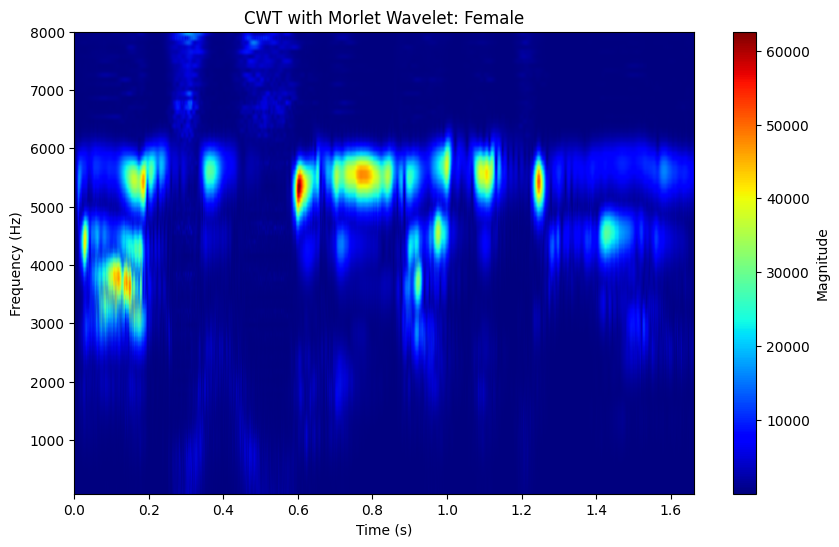

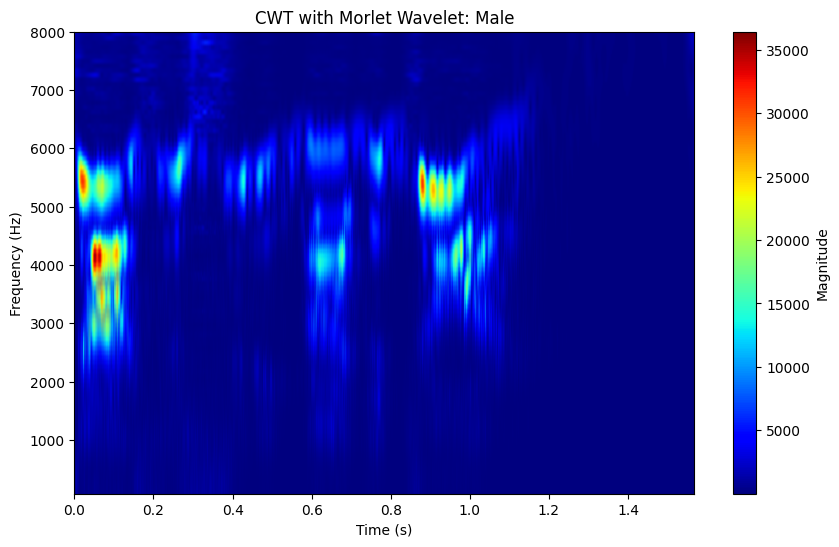

In [18]:
for sex, filename in zip(male_vs_female.index, male_vs_female['filename']):
    cwt_file(filename, visualize=True, title=f'CWT with Morlet Wavelet: {sex.capitalize()}')

# Fourier Representation

In [19]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal1 = wavfile.read(file_list[test_file_idx])
signal2, rate_l = librosa.load(file_list[test_file_idx], sr=None)

modality                                             audio-only
channel                                                  speech
emotion                                                     sad
intensity                                                normal
statement                          Dogs are sitting by the door
repetition                                                    2
actor                                                        23
sex                                                        male
filename                               03-01-04-01-02-02-23.wav
length (s)                                             1.621333
rate (Hz)                                                 48000
amplitudes    [-607, -3223, -2154, -1752, 615, -936, -2418, ...
Name: 42, dtype: object


In [20]:
print(rate == rate_l)
print(signal1 / signal2)
# just scaled down by 2**15 (normalized by maximumum signal)
signal = signal2

True
[32768. 32768. 32768. ... 32768. 32768. 32768.]


/var/folders/tc/hb1c2fsd7hg15551387b8b6w0000gn/T/ipykernel_35382/1270320814.py:2: RuntimeWarning: invalid value encountered in divide
  print(signal1 / signal2)


In [21]:
fft_signal = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), 1/rate)

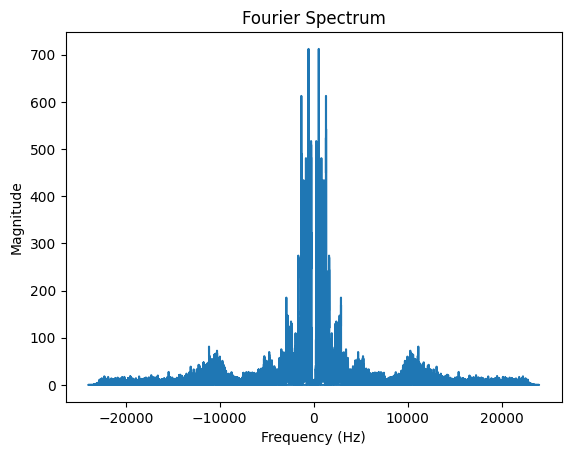

In [22]:
plt.plot(frequencies, np.abs(fft_signal))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum')
plt.show()

Symmetry: A coefficient corresponding to a negative frequency is the complex complex conjugate of the coefficient corresponding to the positive frequency

In [23]:
negative_idx = len(frequencies) // 2 # first half nonnegative, second half negative
assert negative_idx == (frequencies < 0).argmax()
assert (frequencies[1:negative_idx] == -frequencies[negative_idx + 1:][::-1]).all() # exclude one negative due to parity mismatch
positive_signals = fft_signal[1:negative_idx]
negative_signals = fft_signal[negative_idx + 1:][::-1]
assert ((positive_signals + negative_signals).imag == 0).all() # all real
print(positive_signals)
print(negative_signals)

[-2.088533  -0.17723435j -1.4095006 -0.1828146j  -1.0538791 +0.3681108j
 ...  0.05241655+0.00303147j  0.05381917-0.00147586j
  0.05429994+0.00099371j]
[-2.088533  +0.17723435j -1.4095006 +0.1828146j  -1.0538791 -0.3681108j
 ...  0.05241655-0.00303147j  0.05381917+0.00147586j
  0.05429994-0.00099371j]


In [24]:
def fft_file(filename, visualize=False, title='Fourier Spectrum'):
    rate, signal = librosa.load(os.path.join(data_dir, filename), sr=None)
    fft_signal = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/rate)

    if visualize:
        plt.plot(frequencies, np.abs(fft_signal))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(title)
        plt.show()
    
    return fft_signal, frequencies

## Short-Time Fourier Transform

In [25]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

signal, rate = librosa.load(file_list[test_file_idx], sr=None)

modality                                             audio-only
channel                                                  speech
emotion                                                     sad
intensity                                                normal
statement                          Dogs are sitting by the door
repetition                                                    2
actor                                                        23
sex                                                        male
filename                               03-01-04-01-02-02-23.wav
length (s)                                             1.621333
rate (Hz)                                                 48000
amplitudes    [-607, -3223, -2154, -1752, 615, -936, -2418, ...
Name: 42, dtype: object


In [26]:
S = librosa.stft(signal)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

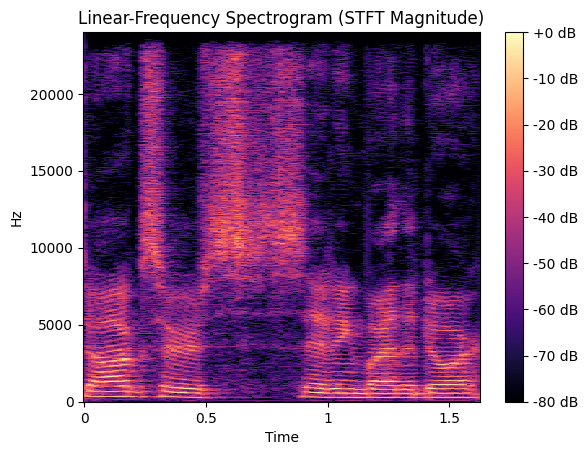

In [27]:
librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=rate)
plt.colorbar(format="%+2.f dB")
plt.title('Linear-Frequency Spectrogram (STFT Magnitude)');

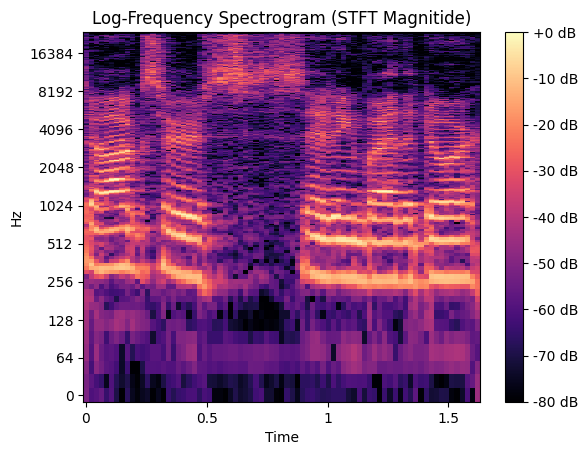

In [28]:
D_1024 = librosa.amplitude_to_db(np.abs(librosa.stft(signal, hop_length=1024)), ref=np.max)
librosa.display.specshow(D_1024, y_axis='log', sr=rate, x_axis='time', hop_length=1024)
plt.colorbar(format="%+2.f dB")
plt.title('Log-Frequency Spectrogram (STFT Magnitide)');

# ERBlet

Implemented by [LTFAT](https://ltfat.org/) (Large Time-Frequency Analysis Toolbox) in Matlab/Octave
- ERBlet Paper: https://ieeexplore.ieee.org/document/6637697
- LTFAT Documentation: https://ltfat.org/doc/
- LTFAT Github: https://github.com/ltfat/ltfat

In [3]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform import *
from plotting import *
from transform_audio import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav-processed')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

In [2]:
test_file_idx = 42

In [3]:
coefs, freqs = erblet_demo(file_list[test_file_idx])

In [4]:
print('freq : samples')
for c, f in zip(coefs, freqs):
    print(f'{round(f):>5} : {len(c)}')

freq : samples
    0 : 566
   26 : 119
   55 : 133
   88 : 148
  124 : 165
  164 : 184
  208 : 205
  258 : 228
  314 : 254
  376 : 283
  445 : 315
  521 : 351
  607 : 390
  702 : 435
  808 : 484
  926 : 540
 1058 : 601
 1205 : 670
 1368 : 746
 1550 : 831
 1753 : 925
 1979 : 1031
 2231 : 1148
 2511 : 1279
 2823 : 1425
 3171 : 1587
 3558 : 1768
 3990 : 1969
 4471 : 2194
 5007 : 2444
 5603 : 2722
 6268 : 3032
 7009 : 3378
 7834 : 3763
 8753 : 4192
 9776 : 4669
10917 : 5202
12187 : 5794
13602 : 6455
15179 : 7190
16935 : 8010
18891 : 8923
21070 : 9940
23498 : 11073
24000 : 30920


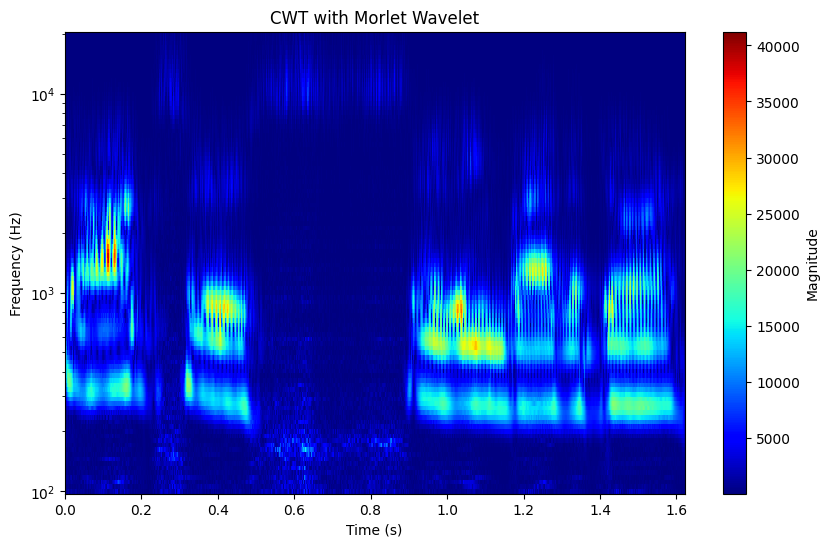

In [5]:
cwt_file(file_list[test_file_idx], low_freq=100, high_freq=20000, visualize=True);

In [6]:
if USE_MATLAB:
    eng.quit() # will remove erblet figure